# Structural Estimation of Market Parameters

### Simultaneous Estimator, Truncated Normal with Variance, Optim Second Stage

James Yu

In [1]:
using Pkg
Pkg.activate(".")
pkg_list = [
    "BlackBoxOptim", 
    "Cubature", 
    "Distributions", 
    "Integrals", 
    "Optim", 
    "Roots", 
    "FiniteDiff", 
    "PythonPlot", 
    "PrettyTables", 
    "JLD", 
    "StatProfilerHTML",
    "SpecialFunctions"
]
#for pkg in pkg_list 
#    Pkg.add(pkg)
#end

#Pkg.instantiate()

using BlackBoxOptim, Cubature, Distributions, Integrals, Optim, Random, Roots, FiniteDiff, PythonPlot, PrettyTables, JLD, SpecialFunctions

  Activating project at `C:\Users\jbrig\Documents\research\mapinator_2024`
    CondaPkg Found dependencies: C:\Users\jbrig\.julia\packages\PythonCall\Nr75f\CondaPkg.toml
    CondaPkg Found dependencies: C:\Users\jbrig\.julia\packages\PythonPlot\469aA\CondaPkg.toml
    CondaPkg Dependencies already up to date


# STEP 1: Get placements matrix

In [2]:
type_allocation_res = load("type_allocation_results_4.jld")
placement_rates_raw = type_allocation_res["placement_rates"]
unmatched_raw = type_allocation_res["unmatched"]
k = size(placement_rates_raw)[2]
K = size(placement_rates_raw)[1]

# conduct adjustment using the relative m_t values
m_t_values = type_allocation_res["m_t_values"]
m_t_placements = zeros(Int, k)
for t in 1:k
    m_t_placements[t] = sum(placement_rates_raw[:, t]) + unmatched_raw[t]
end

placement_rates_rescaled = zeros(Int, K, k)
for i in 1:K
    for t in 1:k
        placement_rates_rescaled[i, t] = round(m_t_values[t] * (placement_rates_raw[i, t] / m_t_placements[t]))
    end
end

# collapse the last three sinks together
println("original dimensions: ", K, " by ", k)
K -= 2
K -= 1
println("new dimensions: ", K, " by ", k)

placement_rates = zeros(Int, K, k)
for i in 1:3 # NOTE: hardcoded
    for t in 1:k
        placement_rates[i, t] = placement_rates_rescaled[i, t]
    end
end

for i in 4:7 # NOTE: hardcoded
    for t in 1:k
        placement_rates[i-1, t] += placement_rates_rescaled[i, t]
    end
end

for t in 1:k
    for original_sink_tier in [K+2, K+3] # NOTE: hardcoded
        placement_rates[K, t] += placement_rates_rescaled[original_sink_tier, t] 
    end
end

estimated_m_val = sum(m_t_values[1:k])
estimated_γ = m_t_values[1:k] / estimated_m_val

original dimensions: 9 by 4
new dimensions: 6 by 4


4-element Vector{Float64}:
 0.20711305886814715
 0.26071383422527494
 0.3301167249589145
 0.2020563819476634

In [3]:
placement_rates_raw_table = zeros(Int, K, k)
for i in 1:3 # NOTE: hardcoded
    for t in 1:k
        placement_rates_raw_table[i, t] = placement_rates_raw[i, t]
    end
end

for i in 4:7 # NOTE: hardcoded
    for t in 1:k
        placement_rates_raw_table[i-1, t] += placement_rates_raw[i, t]
    end
end

for t in 1:k
    for original_sink_tier in [K+2, K+3] # NOTE: hardcoded
        placement_rates_raw_table[K, t] += placement_rates_raw[original_sink_tier, t] 
    end
end

In [4]:
placement_rates_raw

9×4 Matrix{Int64}:
  880   141   56    8
  938   547  158   31
 1147  1320  703   72
   95   220  247  211
  600   565  331   81
  727   428  243   76
  215   190  120   42
  149   245  349  287
  425   634  655  268

In [5]:
placement_rates

6×4 Matrix{Int64}:
  788   182   122    26
  840   704   344    99
 1112  1983  2068   904
  537   728   720   259
  651   551   529   243
  705  1376  2447  1908

In [6]:
m_t_values

4-element Vector{Int64}:
 4915
 6187
 7834
 4795

In [7]:
include("type_allocation_base.jl")

Main.SBM

In [8]:
sink_names_to_present = [
    "Tier 3 + Tier 4",
    "Public Sector",
    "Private Sector",
    "Other"
]
SBM.nice_table(placement_rates_raw_table, k, k-2, 4, sink_names_to_present)

┌─────────────────┬────────┬────────┬────────┬────────┬────────────┐
│                 │ Tier 1 │ Tier 2 │ Tier 3 │ Tier 4 │ Row Totals │
├─────────────────┼────────┼────────┼────────┼────────┼────────────┤
│          Tier 1 │    880 │    141 │     56 │      8 │       1085 │
│          Tier 2 │    938 │    547 │    158 │     31 │       1674 │
│ Tier 3 + Tier 4 │   1242 │   1540 │    950 │    283 │       4015 │
│   Public Sector │    600 │    565 │    331 │     81 │       1577 │
│  Private Sector │    727 │    428 │    243 │     76 │       1474 │
│           Other │    789 │   1069 │   1124 │    597 │       3579 │
│   Column Totals │   5176 │   4290 │   2862 │   1076 │      13404 │
└─────────────────┴────────┴────────┴────────┴────────┴────────────┘
\begin{tabular}{rrrrrr}
  \hline
   & \textbf{Tier 1} & \textbf{Tier 2} & \textbf{Tier 3} & \textbf{Tier 4} & \textbf{Row Totals} \\\hline
  Tier 1 & 880 & 141 & 56 & 8 & 1085 \\
  Tier 2 & 938 & 547 & 158 & 31 & 1674 \\
  Tier 3 + Tier 4 & 

In [9]:
SBM.nice_table(placement_rates, k, k-2, 4, sink_names_to_present)

┌─────────────────┬────────┬────────┬────────┬────────┬────────────┐
│                 │ Tier 1 │ Tier 2 │ Tier 3 │ Tier 4 │ Row Totals │
├─────────────────┼────────┼────────┼────────┼────────┼────────────┤
│          Tier 1 │    788 │    182 │    122 │     26 │       1118 │
│          Tier 2 │    840 │    704 │    344 │     99 │       1987 │
│ Tier 3 + Tier 4 │   1112 │   1983 │   2068 │    904 │       6067 │
│   Public Sector │    537 │    728 │    720 │    259 │       2244 │
│  Private Sector │    651 │    551 │    529 │    243 │       1974 │
│           Other │    705 │   1376 │   2447 │   1908 │       6436 │
│   Column Totals │   4633 │   5524 │   6230 │   3439 │      19826 │
└─────────────────┴────────┴────────┴────────┴────────┴────────────┘
\begin{tabular}{rrrrrr}
  \hline
   & \textbf{Tier 1} & \textbf{Tier 2} & \textbf{Tier 3} & \textbf{Tier 4} & \textbf{Row Totals} \\\hline
  Tier 1 & 788 & 182 & 122 & 26 & 1118 \\
  Tier 2 & 840 & 704 & 344 & 99 & 1987 \\
  Tier 3 + Tier 4 

In [10]:
pretty_table(reshape(m_t_values, 1, k), header = ["Tier $i" for i in 1:k], backend=Val(:latex))

\begin{tabular}{rrrr}
  \hline
  \textbf{Tier 1} & \textbf{Tier 2} & \textbf{Tier 3} & \textbf{Tier 4} \\\hline
  4915 & 6187 & 7834 & 4795 \\\hline
\end{tabular}


In [11]:
function Fx(t, α, v_rel)
    return 1 - sum([-log(v_rel[j])*sum(α[1:j]) for j in 1:t])
end

function F(x, ρ, normals, K)
    sum_base = 0.0
    for i in 1:K
        sum_base += ρ[i] * cdf(normals[i], x)
    end
    return sum_base
end

function f_integrand(integrals, x, p) 
    base_exp = exp(F(x, p.ρ, p.normals, p.K) / sum(p.α[1:p.s]))
    for i in 1:p.K
        integrals[i] = base_exp * pdf(p.normals[i], x)
    end
end

function get_integrals(x_vec, ρ, normals, α, k, K)
    # Fx_vec = [F(x0)=1, F(x1), F(x2), F(x3), ..., F(xk-1)]
    # x_vec = [x0 = 1, x1, x2, x3, ..., xk = 0]
    # x_vec[s] = x_{s-1}, so the limits of integration are and must be offset by 1 below
    all_integrals = zeros(K, k)
    for s in 1:k
        # https://docs.sciml.ai/Integrals/stable/basics/SampledIntegralProblem/ might be faster
        # if f_integrand(x) can be vectorized/sped up
        prob = IntegralProblem(IntegralFunction(f_integrand, zeros(K)), (x_vec[s+1], x_vec[s]), (; s, ρ, normals, α, K))
        sol = solve(prob, CubatureJLh(); reltol = 1e-3, abstol = 1e-3)
        integrals_result = sol.u
        # NOTE: result may be inf if alpha_1 is too small
        # NOTE: some parameter values for μ and σ may cause the cdf F_i to be NaN
        for i in 1:K 
            all_integrals[i, s] = integrals_result[i]
            #if integrals_result[i] == 0.0
            #    println((F(x_vec[s], ρ, normals, K), F(x_vec[s+1], ρ, normals, K), x_vec, s, normals[i]))
            #end
        end
    end
    return all_integrals
end      

function q(i, t, all_integrals, Fx_vec, α, v_rel, k)
    return α[t] * sum([(1/sum(α[1:s])) * prod([v_rel[j] for j in t:(s-1)]) * exp(-Fx_vec[s] / sum(α[1:s])) * all_integrals[i, s] for s in t:k])
end

q (generic function with 1 method)

# STEP 2: Estimate global maximum likelihood

In [12]:
function estimate_likelihood_2(p_vec, γ, placements, k, K, m_val, counter; get_full = false)   
    μ = p_vec[1:K]
    σ = p_vec[K+1:2K]

    for i in 1:K
        if abs(abs(erf((-μ[i]/σ[i]) / sqrt(2))) - 1) < 1e-3
            if get_full
                return -Inf
            else
                return Inf
            end
        end
    end

    
    ρ_vec = p_vec[2K+1:3K]
    ρ = ρ_vec / sum(ρ_vec)

    v_rel = p_vec[3K+1:3K+k-1]
    τ = p_vec[3K+k]
    α = γ * τ

    ## compute the cutoffs x and the CDF values F(x)
    normals = [truncated(Normal(μ[i], σ[i]), 0, 1) for i in 1:K]

    Fx_vec = ones(k) # sets F(x0) = 1 by default; Fx_vec = [F(x0)=1, F(x1), F(x2), F(x3), ..., F(xk-1)]
    x_vec = ones(k+1) # x_vec = [x0 = 1, x1, x2, x3, ..., xk = 0]
    x_vec[k+1] = 0.0
    for t in 1:k-1
        Fx_vec_candidate = Fx(t, α, v_rel)
        if Fx_vec_candidate <= 0.0 # if τ * sum(log(v_rel)) is too negative (v_rel too small, τ too big), Fx_vec[i] < 0 can occur
            Fx_vec[t+1:k] .= 0.0
            x_vec[t+1:k] .= 0.0
            break
        end

        Fx_vec[t+1] = Fx_vec_candidate
        # there is no simple closed-form for F^{-1}(x) so this numerically computes x1, x2, x3
        x_vec[t+1] = find_zero(x -> F(x, ρ, normals, K) - Fx_vec[t+1], 0.5) 
    end 

    ρ_q_it = zeros(K, k)
    all_integrals = get_integrals(x_vec, ρ, normals, α, k, K)
    for i in 1:K, t in 1:k
        prob = q(i, t, all_integrals, Fx_vec, α, v_rel, k)
        ρ_q_it[i, t] = ρ[i] * prob
    end

    normalizer = sum(ρ_q_it)
    
    likelihood = 0.0
    for i in 1:K, t in 1:k
        likelihood += placements[i, t] * log(ρ_q_it[i, t] / normalizer)
    end

    counter[1] += 1
    if get_full == true
        likelihood_probability_vector = zeros((k * K))
        total_placements_vector = zeros((k * K))
        vector_counter = 1
        for i in 1:K
            for t in 1:k
                likelihood_probability_vector[vector_counter] = (ρ_q_it[i, t] / normalizer)
                if isnan(likelihood_probability_vector[vector_counter])
                    return -Inf
                end
                total_placements_vector[vector_counter] = placements[i, t]
                vector_counter += 1
            end
        end
        actual_likelihood = loglikelihood(Multinomial(sum(placements), likelihood_probability_vector), total_placements_vector)
        return actual_likelihood
    else
        return -likelihood
    end
end

estimate_likelihood_2 (generic function with 1 method)

In [13]:
# upper/lower bound on the mu parameter of truncated normal
upper_1 = [10.0 for _ in 1:K]
lower_1 = [-10.0 for _ in 1:K]

upper_1[K] = 0.0

# upper/lower bound on the sigma parameter of truncated normal
append!(upper_1, [10.0 for _ in 1:K])
append!(lower_1, [0.0001 for _ in 1:K])

upper_1[2K] = 0.1

# upper/lower bound on values proportional to ρ_i
append!(upper_1, [1.0 for _ in 1:K])
append!(lower_1, [0.0 for _ in 1:K])

# upper/lower bound on v_rel
append!(upper_1, [1.0 for _ in 1:k-1])
append!(lower_1, [0.01 for _ in 1:k-1])

# upper/lower bound on τ
append!(upper_1, [10.0 for _ in 1:1])
append!(lower_1, [0.25 for _ in 1:1])

search_range_1 = [(lower_1[i], upper_1[i]) for i in eachindex(upper_1)]

Random.seed!(0)
NUM_ROUNDS = 19

likelihoods = zeros(NUM_ROUNDS)
sols = zeros(NUM_ROUNDS, length(upper_1))

# this approach with random re-running is similar to that used in/associated with 
#     the SBM MCMC solver package associated with Peixoto (2014)
Threads.@threads for SEED in 1:NUM_ROUNDS
    println("starting round $SEED")
    counter = [0]
    sol_res_1 = bboptimize(p -> estimate_likelihood_2(p, estimated_γ, placement_rates, k, K, estimated_m_val, counter), SearchRange = search_range_1, MaxTime = 600.0, TraceMode = :silent) 
    # MaxTime = 60.0, MaxFuncEvals = 500000,
    sol_1 = best_candidate(sol_res_1)
    actual_likelihood = estimate_likelihood_2(sol_1, estimated_γ, placement_rates, k, K, estimated_m_val, counter; get_full = true)
    likelihoods[SEED] = actual_likelihood
    sols[SEED, :] = sol_1[:]
    estimated_v_rel = sol_1[3K+1:3K+k-1]
    estimated_τ = sol_1[3K+k]
    println("  finished round $SEED with likelihood $actual_likelihood in $(counter[1]) iters")
    println("  ", estimated_v_rel, " ", estimated_τ)
end

best_likelihood = maximum(likelihoods)
best_index = argmax(likelihoods)
best_sol = sols[best_index, :]
println("best likelihood: $best_likelihood")
estimated_v_rel = best_sol[3K+1:3K+k-1]
estimated_τ = best_sol[3K+k]
println(estimated_v_rel)
println(estimated_τ)

starting round 17
starting round 10
starting round 18
starting round 9
starting round 16
starting round 4
starting round 1
starting round 7
starting round 19
starting round 15
starting round 5
starting round 12
starting round 8
starting round 2
starting round 11
starting round 6
starting round 14
starting round 3
starting round 13
  finished round 18 with likelihood -98.42908953630376 in 587196 iters
  [0.6476015566678974, 0.7018113715242387, 0.7731831674153467] 0.6418105061368801
  finished round 8 with likelihood -98.42909581009098 in 674254 iters
  finished round 12 with likelihood -98.42913605605281 in 661004 iters
  [0.6475871381803057, 0.7017745838846587, 0.7730505218598924] 0.6417359924300942
  [0.6475977575659286, 0.7018079148167052, 0.7731693337122673] 0.6418021695402768
  finished round 9 with likelihood -98.42919813456501 in 680647 iters
  finished round 16 with likelihood -98.42938976509868 in 692415 iters
  [0.647583623159711, 0.70178873234913, 0.7730957178178226] 0.641729

In [14]:
sol_1 = best_sol

22-element Vector{Float64}:
  0.11476289581913392
  0.10591041266194651
  0.02935940670217284
  0.0329361873590473
 -0.9992599770498448
 -0.17113726177170874
  0.17825445974029924
  0.06608757087757317
  0.05898431687552398
  0.07051959879783025
  0.30367781774506547
  0.052009078215387
  0.08030466195664085
  0.15929166336008596
  0.5804207099458514
  0.20670703101055204
  0.1829528184521685
  0.9759425565388439
  0.6476015566678974
  0.7018113715242387
  0.7731831674153467
  0.6418105061368801

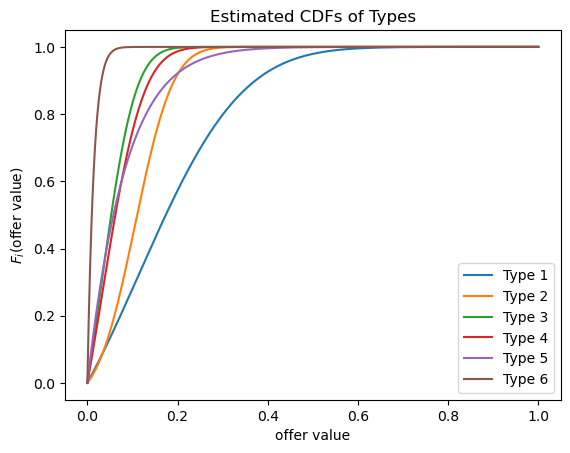

In [15]:
point_grid = [i for i in range(0, 1; length = 10001)]
for select_type in 1:K
    plot(point_grid, [cdf(truncated(Normal(sol_1[select_type], sol_1[select_type+K]), 0, 1), x) for x in point_grid], label = string("Type ", select_type))
end

title("Estimated CDFs of Types")
xlabel("offer value")
ylabel("\$F_i\$(offer value\$)\$")
legend();

# STEP 3: locally improve the estimate

In [17]:
function estimate_likelihood_3(p_vec, μ_K, σ_K, γ, placements, k, K, m_val)   
    Km1 = K - 1
    μ = zeros(K)
    σ = zeros(K)
    μ[1:Km1] = p_vec[1:Km1]
    σ[1:Km1] = p_vec[Km1+1:2Km1]
    μ[K] = μ_K
    σ[K] = σ_K
    
    ρ = zeros(K)
    ρ[1:Km1] = p_vec[2Km1+1:3Km1]
    ρ[K] = 1 - sum(ρ[1:Km1])
    v_rel = p_vec[3Km1+1:3Km1+k-1]
    τ = p_vec[3Km1+k]
    α = γ * τ

    ## compute the cutoffs x and the CDF values F(x)
    normals = [truncated(Normal(μ[i], σ[i]), 0, 1) for i in 1:K]

    Fx_vec = ones(k) # sets F(x0) = 1 by default; Fx_vec = [F(x0)=1, F(x1), F(x2), F(x3), ..., F(xk-1)]
    x_vec = ones(k+1) # x_vec = [x0 = 1, x1, x2, x3, ..., xk = 0]
    x_vec[k+1] = 0.0
    for t in 1:k-1
        Fx_vec_candidate = Fx(t, α, v_rel)
        if Fx_vec_candidate <= 0.0
            Fx_vec[t+1:k] .= 0.0
            x_vec[t+1:k] .= 0.0
            break
        end

        Fx_vec[t+1] = Fx_vec_candidate
        # there is no simple closed-form for F^{-1}(x) so this numerically computes x1, x2, x3
        x_vec[t+1] = find_zero(x -> F(x, ρ, normals, K) - Fx_vec[t+1], 0.5) 
    end 

    ρ_q_it = zeros(K, k)
    all_integrals = get_integrals(x_vec, ρ, normals, α, k, K)
    for i in 1:K, t in 1:k
        prob = q(i, t, all_integrals, Fx_vec, α, v_rel, k)
        ρ_q_it[i, t] = ρ[i] * prob
    end

    normalizer = sum(ρ_q_it)
    likelihood = 0.0
    for i in 1:K, t in 1:k
        likelihood += placements[i, t] * log(ρ_q_it[i, t] / normalizer)
    end

    if isnan(likelihood) || isinf(likelihood)
        println(likelihood)
    end

    return -likelihood
end

estimate_likelihood_3 (generic function with 1 method)

In [18]:
function get_initial_condition(p_vec, k, K)
    Km1 = K - 1
    output = zeros(3Km1 + k)
    output[1:Km1] = p_vec[1:Km1]
    output[Km1+1:2Km1] = p_vec[K+1:K + Km1]
    ρ_vec = p_vec[2K+1:3K] / sum(p_vec[2K+1:3K])
    output[2Km1+1:3Km1] = ρ_vec[1:Km1]
    output[3Km1+1:3Km1+k] = p_vec[3K+1:3K+k]
    return output
end

function con_c!(c, x) 
    Km1 = K - 1
    c[1] = 1 - sum(x[2Km1+1:3Km1])
    #for i in 1:K
    #   c[i+1] = abs(abs(erf((-x[i]/x[K+i]) / sqrt(2))) - 1)
    #end
    c
end

con_c! (generic function with 1 method)

In [19]:
Random.seed!(0)

# upper/lower bound on the mu parameter of truncated normal
upper_2 = [5.0 for _ in 1:K-1]
lower_2 = [-5.0 for _ in 1:K-1]

# upper/lower bound on the sigma parameter of truncated normal
append!(upper_2, [10.0 for _ in 1:K-1])
append!(lower_2, [0.001 for _ in 1:K-1])

#upper_2[K] = sol_1[K]
#lower_2[K] = sol_1[K]
#upper_2[2K] = sol_1[2K]
#lower_2[2K] = sol_1[2K]

# upper/lower bound on ρ_i
append!(upper_2, [1.0 for _ in 1:K-1])
append!(lower_2, [0.0 for _ in 1:K-1])

# upper/lower bound on v_rel
append!(upper_2, [1.0 for _ in 1:k-1])
append!(lower_2, [0.01 for _ in 1:k-1])

# upper/lower bound on τ
append!(upper_2, [10.0 for _ in 1:1])
append!(lower_2, [0.25 for _ in 1:1])

x0 = get_initial_condition(sol_1, k, K)
lx = lower_2
ux = upper_2
lc = [0.0]
uc = [1.0]

#append!(uc, [Inf for _ in 1:K])
#append!(lc, [1e-3 for _ in 1:K])
println(con_c!(zeros(1), x0))
df = TwiceDifferentiable(p -> estimate_likelihood_3(p, sol_1[K], sol_1[2K], estimated_γ, placement_rates, k, K, estimated_m_val), x0)
dfc = TwiceDifferentiableConstraints(con_c!, lx, ux, lc, uc)
sol_res_2 = optimize(df, dfc, x0, IPNewton())
sol_2 = Optim.minimizer(sol_res_2)

[0.4465290425740208]


19-element Vector{Float64}:
  0.09742627210339551
  0.10162506629592707
  0.023206021212955903
  0.025171336464611574
 -2.6779326537140062
  0.18780618708740698
  0.06645867574163494
  0.059494114726556926
  0.07168672725867416
  0.46979252657232334
  0.03673814313893503
  0.072972805990283
  0.26711315194415214
  0.09502790722805415
  0.08398628090309186
  0.6473725357418028
  0.7010530107443342
  0.7699580669037088
  0.639746655631436

In [20]:
x0

19-element Vector{Float64}:
  0.11476289581913392
  0.10591041266194651
  0.02935940670217284
  0.0329361873590473
 -0.9992599770498448
  0.17825445974029924
  0.06608757087757317
  0.05898431687552398
  0.07051959879783025
  0.30367781774506547
  0.03674228936680457
  0.07288170133953105
  0.26556348236458827
  0.09457594817650165
  0.08370753617855367
  0.6476015566678974
  0.7018113715242387
  0.7731831674153467
  0.6418105061368801

In [21]:
sol_res_2

 * Status: success

 * Candidate solution
    Final objective value:     5.700328e+04

 * Found with
    Algorithm:     Interior Point Newton

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 5.00e-01 ≰ 1.0e-08

 * Work counters
    Seconds run:   7  (vs limit Inf)
    Iterations:    21
    f(x) calls:    61
    ∇f(x) calls:   61


In [22]:
x0 - sol_2

19-element Vector{Float64}:
  0.01733662371573841
  0.004285346366019432
  0.006153385489216935
  0.007764850894435724
  1.6786726766641613
 -0.009551727347107741
 -0.00037110486406177756
 -0.0005097978510329448
 -0.001167128460843908
 -0.16611470882725787
  4.146227869539221e-6
 -9.110465075194696e-5
 -0.0015496695795638726
 -0.00045195905155250016
 -0.00027874472453819077
  0.00022902092609466962
  0.0007583607799044323
  0.003225100511637824
  0.002063850505444109

In [23]:
Km1 = K - 1
estimated_v_rel = sol_2[3Km1+1:3Km1+k-1]
estimated_τ = sol_2[3Km1+k]

0.639746655631436

In [24]:
println("estimated value ratios:")
display(estimated_v_rel)
println()
estimated_v_base = 1
for i in 1:k
    println("v", i, ": ", estimated_v_base)
    if i != k
        estimated_v_base = estimated_v_rel[i] * estimated_v_base
    end
end
println()

println("estimated market balance ratio (m / (n-1)): ", estimated_τ)

#estimated_n_val = (estimated_m_val / estimated_τ) + 1
#println("estimated total departments: ", estimated_n_val)
estimated_α = estimated_τ * estimated_γ
println("estimated α_t: ", estimated_α)

estimated value ratios:


3-element Vector{Float64}:
 0.6473725357418028
 0.7010530107443342
 0.7699580669037088


v1: 1
v2: 0.6473725357418028
v3: 0.45384246525498495
v4: 0.34943966722654185

estimated market balance ratio (m / (n-1)): 0.639746655631436
estimated α_t: [0.13249988674849386, 0.16679080352246825, 0.2111910707604681, 0.1292648946000057]


In [25]:
estimated_μ = sol_2[1:Km1]
estimated_σ = sol_2[Km1+1:2Km1]
estimated_ρ = sol_2[2Km1+1:3Km1];

In [26]:
estimated_μ

5-element Vector{Float64}:
  0.09742627210339551
  0.10162506629592707
  0.023206021212955903
  0.025171336464611574
 -2.6779326537140062

In [27]:
estimated_σ

5-element Vector{Float64}:
 0.18780618708740698
 0.06645867574163494
 0.059494114726556926
 0.07168672725867416
 0.46979252657232334

In [28]:
estimated_ρ

5-element Vector{Float64}:
 0.03673814313893503
 0.072972805990283
 0.26711315194415214
 0.09502790722805415
 0.08398628090309186

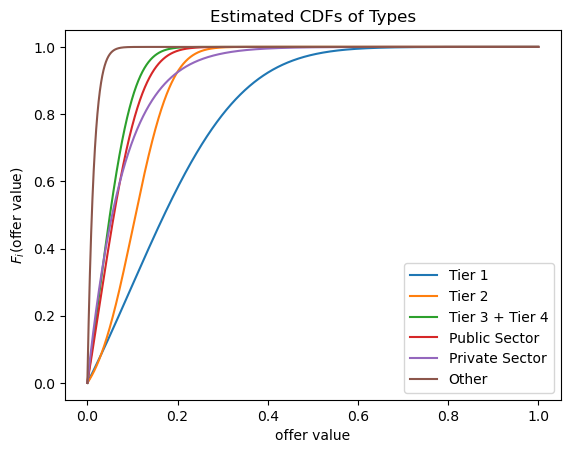

Python: None

In [29]:
point_grid = [i for i in range(0, 1; length = 10001)]
plot_labels = ["Tier 1", "Tier 2", "Tier 3 + Tier 4", 
    "Public Sector",
    "Private Sector",
    "Other"]
for select_type in 1:Km1
    plot(point_grid, [cdf(truncated(Normal(sol_2[select_type], sol_2[select_type+Km1]), 0, 1), x) for x in point_grid], label = plot_labels[select_type])
end
plot(point_grid, [cdf(truncated(Normal(sol_1[K], sol_1[2K]), 0, 1), x) for x in point_grid], label = plot_labels[K])
title("Estimated CDFs of Types")
xlabel("offer value")
ylabel("\$F_i\$(offer value\$)\$")
legend();
savefig("final_cdfs_.png", dpi = 800)

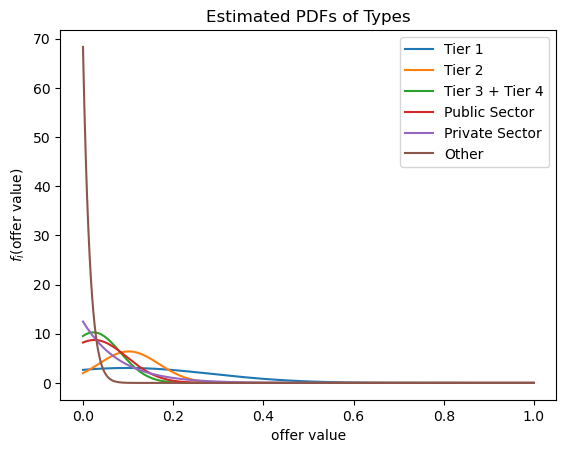

Python: None

In [30]:
point_grid = [i for i in range(0, 1; length = 10001)]
for select_type in 1:Km1
    plot(point_grid, [pdf(truncated(Normal(sol_2[select_type], sol_2[select_type+Km1]), 0, 1), x) for x in point_grid], label = plot_labels[select_type])
end
plot(point_grid, [pdf(truncated(Normal(sol_1[K], sol_1[2K]), 0, 1), x) for x in point_grid], label = plot_labels[K])
title("Estimated PDFs of Types")
xlabel("offer value")
ylabel("\$f_i\$(offer value\$)\$")
legend();
savefig("final_pdfs_.png", dpi = 800)

In [31]:
for select_type in 1:Km1
    println("Type $(select_type):")
    println("  est. mean:   ", mean(truncated(Normal(sol_2[select_type], sol_2[select_type+Km1]), 0, 1)))
    println("  est. stddev: ", std(truncated(Normal(sol_2[select_type], sol_2[select_type+Km1]), 0, 1)))
    println()
end

println("Type $K:")
    println("  est. mean:   ", mean(truncated(Normal(sol_1[K], sol_1[2K]), 0, 1)))
    println("  est. stddev: ", std(truncated(Normal(sol_1[K], sol_1[2K]), 0, 1)))
    println()

Type 1:
  est. mean:   0.19124749700560795
  est. stddev: 0.13163226566470607

Type 2:
  est. mean:   0.11041573391377917
  est. stddev: 0.058703727008721895

Type 3:
  est. mean:   0.05695525658610387
  est. stddev: 0.04021633159344922

Type 4:
  est. mean:   0.06736657122333614
  est. stddev: 0.04792117045107025

Type 5:
  est. mean:   0.07798466903975099
  est. stddev: 0.07605379711412863

Type 6:
  est. mean:   0.01372280138933396
  est. stddev: 0.012967123244402258



In [32]:
function estimate_likelihood_2_for_variance(p_vec, μ_K, σ_K, γ, placements, k, K, show_m = false)   
    Km1 = K - 1
    μ = zeros(K)
    σ = zeros(K)
    μ[1:Km1] = p_vec[1:Km1]
    σ[1:Km1] = p_vec[Km1+1:2Km1]
    μ[K] = μ_K
    σ[K] = σ_K
    
    ρ = zeros(K)
    ρ[1:Km1] = p_vec[2Km1+1:3Km1]
    ρ[K] = 1 - sum(ρ[1:Km1])
    v_rel = p_vec[3Km1+1:3Km1+k-1]
    τ = p_vec[3Km1+k]
    α = γ * τ

    ## compute the cutoffs x and the CDF values F(x)
    normals = [truncated(Normal(μ[i], σ[i]), 0, 1) for i in 1:K]

    Fx_vec = ones(k) # sets F(x0) = 1 by default; Fx_vec = [F(x0)=1, F(x1), F(x2), F(x3), ..., F(xk-1)]
    x_vec = ones(k+1) # x_vec = [x0 = 1, x1, x2, x3, ..., xk = 0]
    x_vec[k+1] = 0.0
    for t in 1:k-1
        Fx_vec_candidate = Fx(t, α, v_rel)
        if Fx_vec_candidate <= 0.0 # TODO: if this case occurs, can we speed up q()?
            Fx_vec[t+1:k] .= 0.0
            x_vec[t+1:k] .= 0.0
            break
        end
        Fx_vec[t+1] = Fx_vec_candidate
        # there is no simple closed-form for F^{-1}(x) so this numerically computes x1, x2, x3
        x_vec[t+1] = find_zero(x -> F(x, ρ, normals, K) - Fx_vec[t+1], 0.5) 
    end 

    ρ_q_it = zeros(K, k)
    all_integrals = get_integrals(x_vec, ρ, normals, α, k, K)
    for i in 1:K, t in 1:k
        prob = q(i, t, all_integrals, Fx_vec, α, v_rel, k)
        ρ_q_it[i, t] = ρ[i] * prob
    end

    normalizer = sum(ρ_q_it)
    if show_m
        println("n: ", sum(placements) / normalizer)
        println("m: ", τ * ((sum(placements) / normalizer) - 1))
    end
    
    likelihood_probability_vector = zeros(k * K)
    total_placements_vector = zeros(k * K)
    vector_counter = 1
    for i in 1:K
        for t in 1:k
            likelihood_probability_vector[vector_counter] = (ρ_q_it[i, t] / normalizer)
            total_placements_vector[vector_counter] = placements[i, t]
            vector_counter += 1
        end
    end
    M = sum(placements)
    actual_likelihood = loglikelihood(Multinomial(M, likelihood_probability_vector), total_placements_vector)
    return actual_likelihood
end

estimate_likelihood_2_for_variance (generic function with 2 methods)

In [33]:
sol_1_for_variance = sol_2

19-element Vector{Float64}:
  0.09742627210339551
  0.10162506629592707
  0.023206021212955903
  0.025171336464611574
 -2.6779326537140062
  0.18780618708740698
  0.06645867574163494
  0.059494114726556926
  0.07168672725867416
  0.46979252657232334
  0.03673814313893503
  0.072972805990283
  0.26711315194415214
  0.09502790722805415
  0.08398628090309186
  0.6473725357418028
  0.7010530107443342
  0.7699580669037088
  0.639746655631436

In [34]:
estimate_likelihood_2_for_variance(sol_1_for_variance, sol_1[K], sol_1[2K], estimated_γ, placement_rates, k, K, true)

n: 39893.949146791696
m: 25521.380799934934


-98.33601450538481

In [35]:
estimated_m_val

23731

In [36]:
likelihood_hessian = FiniteDiff.finite_difference_hessian(p -> estimate_likelihood_2_for_variance(p, sol_1[K], sol_1[2K], estimated_γ, placement_rates, k, K), sol_1_for_variance)

19×19 LinearAlgebra.Symmetric{Float64, Matrix{Float64}}:
  -6526.98       5534.82         2794.54       …     -48.5457    1026.41
   5534.82    -119177.0         51515.0             2121.85     -2571.68
   2794.54      51515.0            -1.20241e5         99.9897    3974.95
   1431.21      21728.8         36469.8             -187.958     1862.32
     97.7107      891.464         844.089            -45.5999     219.743
  -7252.37       6575.93         2301.85       …     -21.4697     961.491
   6573.99     -61881.0         19942.4             -736.887    -4594.41
   6463.17          1.10989e5      -2.31513e5       1636.9       3097.1
   3386.16      46385.5         64809.0              360.618     1843.8
   1160.92      10688.8         10067.4             -539.56      2620.76
 -19338.2       20892.6         -5419.68       …  -12364.8      57125.8
    -76.599    -38184.3          2179.36          -13111.6      46624.4
   -153.333      4647.8        -47682.7            -9444.36     24013

In [37]:
estimator_variance = inv((-1 * likelihood_hessian))

19×19 LinearAlgebra.Symmetric{Float64, Matrix{Float64}}:
  0.00976897    0.00291817    0.00126456   …   0.0020623     0.00147574
  0.00291817    0.00188328    0.00056853       0.00129972    0.000901024
  0.00126456    0.00056853    0.000498061      0.00043171    0.000300079
  0.00161786    0.000675695   0.000477572      0.000501704   0.000350658
  0.0011235     0.000757664   0.000314014      0.000518464   0.000264742
 -0.00118771    0.00241373    0.000233653  …   0.00163203    0.00115293
  0.00141406    0.00107814    0.000228124      0.00073801    0.000519284
  0.00132409    0.00099269    0.000129678      0.000668833   0.00045883
  0.0014932     0.00118071    0.000195981      0.000799289   0.000552527
  0.00664756    0.00448207    0.00122642       0.00310547    0.00220432
  4.88464e-6    6.26797e-6    2.5657e-6    …   1.09366e-5    3.16022e-5
 -1.77397e-5   -1.01234e-5   -5.22113e-6       3.90798e-6    4.24062e-5
 -0.000672047  -0.000401504  -0.00017457      -0.000270909  -0.000112601


In [38]:
println([estimator_variance[i, i] for i in 1:3Km1+k]) # variance estimates

[0.009768972064951264, 0.001883283067191928, 0.0004980611375434833, 0.0008835517742193325, 0.12150070608511718, 0.008100978668163455, 0.0007161257940823255, 0.000620333750894032, 0.0009441348077667685, 0.011754119383911526, 2.1605031340985955e-6, 5.217473826076029e-6, 0.00011216478776610202, 1.3873861697185862e-5, 1.0855591196197198e-5, 0.00043295617453227055, 0.00032222721939580644, 0.0011073163136538094, 0.0014270782952842062]


In [39]:
println([sqrt(estimator_variance[i, i]) for i in 1:3Km1+k]) # standard deviations

[0.09883811038739694, 0.04339680941258157, 0.022317283381798135, 0.029724598806701034, 0.34856951399271446, 0.0900054368811321, 0.026760526790075068, 0.02490650017352964, 0.030726776722701788, 0.10841641657937015, 0.001469865005399678, 0.002284179026713105, 0.010590787872774244, 0.003724763307538596, 0.003294782420160275, 0.020807598961251405, 0.017950688549351147, 0.03327636268665506, 0.03777668984022033]


In [40]:
println("standard deviations:")
println("      μ: ", [sqrt(estimator_variance[i, i]) for i in 1:Km1])
println("      σ: ", [sqrt(estimator_variance[i, i]) for i in Km1+1:2Km1])
println("      ρ: ", [sqrt(estimator_variance[i, i]) for i in 2Km1+1:3Km1])
println("  v_rel: ", [sqrt(estimator_variance[i, i]) for i in 3Km1+1:3Km1+k-1])
println("      τ: ", sqrt(estimator_variance[3Km1+k, 3Km1+k]))

standard deviations:
      μ: [0.09883811038739694, 0.04339680941258157, 0.022317283381798135, 0.029724598806701034, 0.34856951399271446]
      σ: [0.0900054368811321, 0.026760526790075068, 0.02490650017352964, 0.030726776722701788, 0.10841641657937015]
      ρ: [0.001469865005399678, 0.002284179026713105, 0.010590787872774244, 0.003724763307538596, 0.003294782420160275]
  v_rel: [0.020807598961251405, 0.017950688549351147, 0.03327636268665506]
      τ: 0.03777668984022033


In [41]:
function get_mean(p_vec, i, K)
    Km1 = K - 1
    μ = zeros(K)
    σ = zeros(K)
    μ[1:Km1] = p_vec[1:Km1]
    σ[1:Km1] = p_vec[Km1+1:2Km1]
    return mean(truncated(Normal(μ[i], σ[i]), 0, 1))
end

function get_stddev(p_vec, i, K)
    Km1 = K - 1
    μ = zeros(K)
    σ = zeros(K)
    μ[1:Km1] = p_vec[1:Km1]
    σ[1:Km1] = p_vec[Km1+1:2Km1]
    return std(truncated(Normal(μ[i], σ[i]), 0, 1))
end

function get_v(p_vec, i, K)
    Km1 = K - 1
    v_rel = p_vec[3Km1+1:3Km1+k-1]
    return prod(v_rel[1:i-1])
end

function get_ρ_K(p_vec, K)
    Km1 = K - 1
    ρ = zeros(K)
    ρ[1:Km1] = p_vec[2Km1+1:3Km1]
    ρ[K] = 1 - sum(ρ[1:Km1])
    return ρ[K]
end

get_ρ_K (generic function with 1 method)

In [42]:
mean_variances = zeros(Km1)
stddev_variances = zeros(Km1)

for i in 1:Km1
    mean_gradient = reshape(FiniteDiff.finite_difference_gradient(p -> get_mean(p, i, K), sol_1_for_variance), length(sol_1_for_variance), 1)
    estimated_mean_variance = mean_gradient' * estimator_variance * mean_gradient
    mean_variances[i] = estimated_mean_variance[1, 1]

    stddev_gradient = reshape(FiniteDiff.finite_difference_gradient(p -> get_stddev(p, i, K), sol_1_for_variance), length(sol_1_for_variance), 1)
    estimated_stddev_variance = stddev_gradient' * estimator_variance * stddev_gradient
    stddev_variances[i] = estimated_stddev_variance[1, 1]
end

In [43]:
mean_variances

5-element Vector{Float64}:
 0.006187285176587714
 0.0020914622477354312
 0.0005728565913152889
 0.0008082382878964275
 0.00111424679706861

In [44]:
[sqrt(mean_variances[i]) for i in 1:Km1]

5-element Vector{Float64}:
 0.07865929809366286
 0.04573250756010905
 0.023934422727847206
 0.028429531967593617
 0.03338033548466238

In [45]:
stddev_variances

5-element Vector{Float64}:
 0.0030053620174761643
 0.0005600440338913643
 0.0002724480850040898
 0.0003912236014393975
 0.001012813962845664

In [46]:
[sqrt(stddev_variances[i]) for i in 1:Km1]

5-element Vector{Float64}:
 0.05482118219699539
 0.02366524949987564
 0.01650600148443256
 0.019779373130597376
 0.031824738221164744

In [47]:
v_variances = zeros(k)

for i in 2:k
    v_gradient = reshape(FiniteDiff.finite_difference_gradient(p -> get_v(p, i, K), sol_1_for_variance), length(sol_1_for_variance), 1)
    estimated_v_variance = v_gradient' * estimator_variance * v_gradient
    v_variances[i] = estimated_v_variance[1, 1]
end

In [48]:
v_variances

4-element Vector{Float64}:
 0.0
 0.00043295617453679026
 0.0003449776419455517
 0.0006319892324480473

In [49]:
[sqrt(v_variances[i]) for i in 1:k]

4-element Vector{Float64}:
 0.0
 0.020807598961360012
 0.018573573752661377
 0.025139396023931188

In [50]:
ρ_K_gradient = reshape(FiniteDiff.finite_difference_gradient(p -> get_ρ_K(p, K), sol_1_for_variance), length(sol_1_for_variance), 1)
estimated_ρ_K_variance = ρ_K_gradient' * estimator_variance * ρ_K_gradient
ρ_K_variance = estimated_ρ_K_variance[1, 1]

0.0002836362272901844

In [51]:
sqrt(ρ_K_variance)

0.016841503118492255

In [52]:
function get_results_tables(p_vec, μ_K, σ_K, γ, placements, k, K, estimator_var, mean_var, stddev_var, v_var, ρ_K_var)   
    Km1 = K - 1
    μ = zeros(K)
    σ = zeros(K)
    μ[1:Km1] = p_vec[1:Km1]
    σ[1:Km1] = p_vec[Km1+1:2Km1]
    μ[K] = μ_K
    σ[K] = σ_K
    means = [mean(truncated(Normal(μ[i], σ[i]), 0, 1)) for i in 1:K]
    stddevs = [std(truncated(Normal(μ[i], σ[i]), 0, 1)) for i in 1:K]
    
    ρ = zeros(K)
    ρ[1:Km1] = p_vec[2Km1+1:3Km1]
    ρ[K] = 1 - sum(ρ[1:Km1])

    ρ_var = zeros(K)
    ρ_var[1:Km1] = [estimator_var[i, i] for i in 2Km1+1:3Km1]
    ρ_var[K] = ρ_K_var
    
    v_rel = p_vec[3Km1+1:3Km1+k-1]
    τ = p_vec[3Km1+k]
    α = γ * τ

    values = ones(k)
    v_base = 1
    for i in 1:k
        println("v", i, ": ", v_base)
        if i != k
            v_base = v_rel[i] * v_base
            values[i+1] = round(v_base; digits = 3)
        end
    end
    
    # graduate parameters
    graduate_parameters_table = Matrix(undef, 2, k)
    graduate_parameters_table[1, 1] = "1"
    graduate_parameters_table[1, 2:k] = [string(round.(values[i]; digits = 3), " (", round.(sqrt(v_var[i]); digits = 3), ")") for i in 2:k]
    graduate_parameters_table[2, :] = round.(γ[:], digits = 3)
    graduate_var_names = [raw"$v_i$", raw"$\gamma_i$"]
    graduate_paper_table = hcat(graduate_var_names, graduate_parameters_table)
    T1 = pretty_table(graduate_paper_table; header = vcat([""], ["Tier $i" for i in 1:k]), backend=Val(:latex))
    
    # employer parameters
    employer_parameters_table = Matrix(undef, 3, K)
    employer_parameters_table[1, :] = [string(round.(ρ[i]; digits = 3), " (", round.(sqrt(ρ_var[i]); digits = 3), ")") for i in 1:K]
    employer_parameters_table[2, 1:K-1] = [string(round.(means[i]; digits = 3), " (", round.(sqrt(mean_var[i]); digits = 3), ")") for i in 1:K-1]
    employer_parameters_table[3, 1:K-1] = [string(round.(stddevs[i]; digits = 3), " (", round.(sqrt(stddev_var[i]); digits = 3), ")") for i in 1:K-1]
    employer_parameters_table[2, K] = string(round.(means[K]; digits = 3))
    employer_parameters_table[3, K] = string(round.(stddevs[K]; digits = 3))
    employer_var_names = [raw"$\rho_i$", raw"$mean(F_i)$", raw"$std(F_i)$"]
    employer_paper_table = hcat(employer_var_names, employer_parameters_table)
    T2 = pretty_table(employer_paper_table; header = vcat([""], plot_labels), backend=Val(:latex))
end

get_results_tables (generic function with 1 method)

In [53]:
get_results_tables(sol_2, sol_1[K], sol_1[2K], estimated_γ, placement_rates, k, K, estimator_variance, mean_variances, stddev_variances, v_variances, ρ_K_variance);

v1: 1
v2: 0.6473725357418028
v3: 0.45384246525498495
v4: 0.34943966722654185
\begin{tabular}{rrrrr}
  \hline
   & \textbf{Tier 1} & \textbf{Tier 2} & \textbf{Tier 3} & \textbf{Tier 4} \\\hline
  \$v\_i\$ & 1 & 0.647 (0.021) & 0.454 (0.019) & 0.349 (0.025) \\
  \$\textbackslash{}gamma\_i\$ & 0.207 & 0.261 & 0.33 & 0.202 \\\hline
\end{tabular}
\begin{tabular}{rrrrrrr}
  \hline
   & \textbf{Tier 1} & \textbf{Tier 2} & \textbf{Tier 3 + Tier 4} & \textbf{Public Sector} & \textbf{Private Sector} & \textbf{Other} \\\hline
  \$\textbackslash{}rho\_i\$ & 0.037 (0.001) & 0.073 (0.002) & 0.267 (0.011) & 0.095 (0.004) & 0.084 (0.003) & 0.444 (0.017) \\
  \$mean(F\_i)\$ & 0.191 (0.079) & 0.11 (0.046) & 0.057 (0.024) & 0.067 (0.028) & 0.078 (0.033) & 0.014 \\
  \$std(F\_i)\$ & 0.132 (0.055) & 0.059 (0.024) & 0.04 (0.017) & 0.048 (0.02) & 0.076 (0.032) & 0.013 \\\hline
\end{tabular}


In [54]:
round(estimated_τ; digits = 3)

0.64

In [55]:
round(sqrt(estimator_variance[3Km1+k, 3Km1+k]); digits = 3)

0.038